# A fast velocity computation

## Making a synthetic set

In [1]:
import MotionClouds as mc
N_X, N_X_up, N_T = 64, 512, 256
fx, fy, ft = mc.get_grids(N_X, N_X_up, 1)
sf_0=0.05
env = mc.envelope_gabor(fx, fy, ft, sf_0=sf_0, B_sf=sf_0, V_X=0., V_Y=0., B_V=0)
x = 2 * mc.rectif(mc.random_cloud(env, seed=1973))[0, :] - 1

In [2]:
mc.envelope_gabor?

Signature:
mc.envelope_gabor(
    fx,
    fy,
    ft,
    V_X=1.0,
    V_Y=0.0,
    B_V=0.5,
    sf_0=0.125,
    B_sf=0.1,
    loggabor=True,
    theta=0.0,
    B_theta=0.19634954084936207,
    alpha=0.0,
    **kwargs,
)
Docstring:
Returns the Motion Cloud kernel, that is the product of:
    * a speed envelope
    * an orientation envelope
    * an orientation envelope
File:      /usr/local/lib/python3.9/site-packages/MotionClouds.py
Type:      function


In [3]:
import numpy as np

In [4]:
def sigmoid(x):
    return 2 / (1 + np.exp(-x)) - 1
slope = 2. 
z = np.tanh(slope*x)

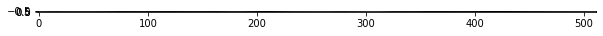

In [5]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10,10))
_ = ax.imshow(z.T, cmap=plt.gray())

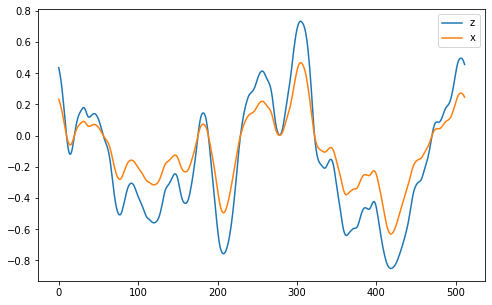

In [6]:
fig, ax = plt.subplots(figsize=(8, 5))
_ = ax.plot(z, label='z')
_ = ax.plot(x, label='x')
plt.legend();

In [7]:
noise = 0.025
I_noise = noise * np.random.randn(N_X, N_T)

In [8]:
up = int(N_X_up/N_X)

In [9]:
I = np.zeros((N_X, N_T))
for i_T in range(N_T):
    I[:, i_T] = np.roll(z, int(i_T*N_X_up/N_T))[::up, 0] 
I += I_noise

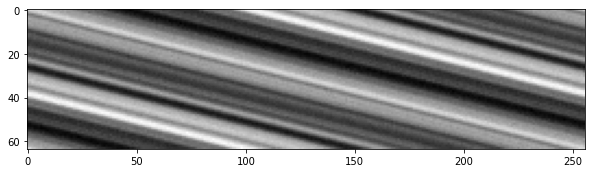

In [10]:
fig, ax = plt.subplots(figsize=(10,10))
_ = ax.imshow(I, cmap=plt.gray())

## transform to events

In [11]:
print(I.min(), I.max())

-0.9222774753058417 0.7886118776690438


In [12]:
#I[20:40, 40:80] = 0
#Ix = np.gradient(I, axis=0)
It = np.gradient(I, axis=1)

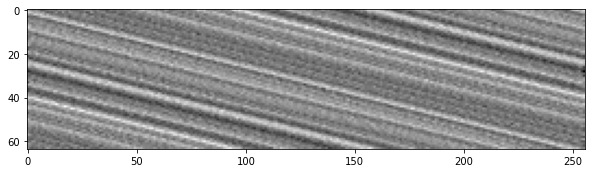

In [13]:
fig, ax = plt.subplots(figsize=(10,10))
_ = ax.imshow(It, cmap=plt.gray())

In [14]:
print(It.min(), It.max())

-0.22565733591779472 0.19785328511372577


In [15]:
threshold = 0.1

In [16]:
It_ = It.copy()
It_event = np.zeros((N_X, N_T))
for i_T in range(N_T-1):
    It_event[:, i_T] = 1. * (It_[:, i_T] > threshold) - 1. * (It_[:, i_T] < -threshold)
    It_[:, i_T+1] -= threshold * It_event[:, i_T]
#It_event[:, -1] = 0

In [17]:
print(It_event.min(), It_event.max())
print(It_.min(), It_.max())

-1.0 1.0
-0.16198099668727528 0.18982784245063053


In [18]:
np.lookfor('seismic')

Search results for 'seismic'
----------------------------
Nothing found.


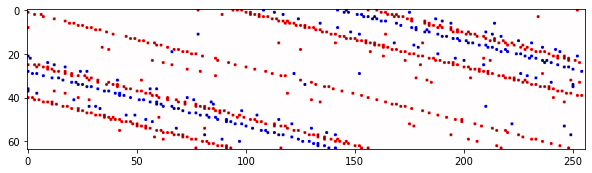

In [19]:
fig, ax = plt.subplots(figsize=(10,10))
_ = ax.imshow(It_event, cmap=plt.cm.seismic, vmin=-1, vmax=1)

In [20]:
It_event[:, 0], It_event[:, 10], It_event[:, -1], It_event.shape

(array([ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  1.,
         0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1., -1.,  0.,
         0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 (64, 256))

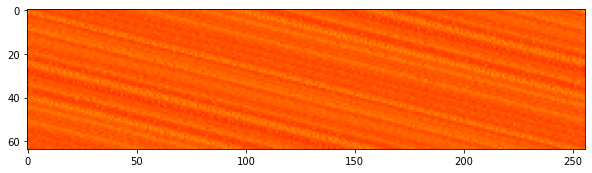

In [21]:
fig, ax = plt.subplots(figsize=(10,10))
_ = ax.imshow(It_, cmap=plt.hot(), vmin=-1, vmax=1)

## motion compensated transform on events

In [22]:
It_v = np.zeros((N_X, N_T))
V = 1.
for i_T in range(N_T):
    It_v[:, i_T] = np.roll(It_event[:, i_T], -int(V*N_X/N_T*i_T))

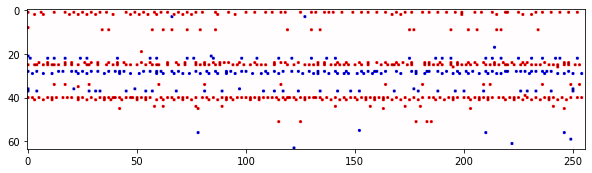

In [23]:
fig, ax = plt.subplots(figsize=(10,10))
_ = ax.imshow(It_v, cmap=plt.cm.seismic, vmin=-1, vmax=1)

In [24]:
It_v[:, 0]

array([ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  1.,
        0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1., -1.,  0.,
        0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [25]:
p_V_plus = np.sum(It_v==1, axis=1)*1.
p_V_minus = np.sum(It_v==-1, axis=1)*1.

p_V_plus /= np.sum(p_V_plus)
p_V_minus /= np.sum(p_V_minus)

In [26]:
np.sum(p_V_minus)

1.0000000000000002

(0.0, 0.3446153846153846)

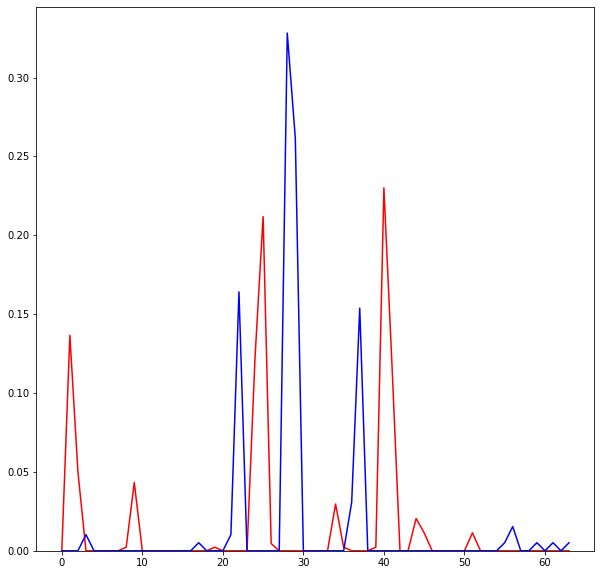

In [27]:
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(p_V_plus, c='r')
ax.plot(p_V_minus, c='b')
ax.set_ylim(0)

In [28]:
entropy = -np.sum( p_V_minus * np.log2(p_V_minus + 1.*(p_V_minus==0)) )
entropy += -np.sum( p_V_plus * np.log2(p_V_plus + 1.*(p_V_plus==0)) )

In [29]:
entropy

5.485855347077767

## transform as an event list

In [30]:
It_event.shape

(64, 256)

In [31]:
import torch

In [32]:
torch.nonzero(torch.Tensor(It_event)).shape, torch.nonzero(torch.Tensor(It_event==1)).shape, torch.nonzero(torch.Tensor(It_v==-1)).shape

(torch.Size([634, 2]), torch.Size([439, 2]), torch.Size([195, 2]))

In [33]:
torch.nonzero(torch.Tensor(It_event))[:10, :]

tensor([[  0,  78],
        [  0,  94],
        [  0,  96],
        [  0,  98],
        [  0, 108],
        [  0, 142],
        [  0, 146],
        [  0, 156],
        [  0, 160],
        [  0, 252]])

x, t, p

In [34]:
events_neg = torch.nonzero(torch.Tensor(It_event==-1))
events_neg.shape, torch.ones(events_neg.shape[0], 1).shape

(torch.Size([195, 2]), torch.Size([195, 1]))

In [35]:
events_neg = torch.hstack((events_neg, -1 * torch.ones(events_neg.shape[0], 1, dtype=int)))
events_neg.shape

torch.Size([195, 3])

In [36]:
events_pos = torch.nonzero(torch.Tensor(It_event==1))
events_pos = torch.hstack((events_pos, torch.ones(events_pos.shape[0], 1, dtype=int)))
events_pos.shape

torch.Size([439, 3])

In [37]:
events = torch.vstack((events_pos, events_neg))
events.shape

torch.Size([634, 3])

In [38]:
events[:10, :]

tensor([[  0,  78,   1],
        [  0,  94,   1],
        [  0,  96,   1],
        [  0,  98,   1],
        [  0, 156,   1],
        [  0, 160,   1],
        [  0, 252,   1],
        [  1,   0,   1],
        [  1, 100,   1],
        [  1, 102,   1]])

In [39]:
times, indices = torch.sort(events[:, 1])
events = events[indices, :]

In [40]:
# x, t, p
events[:10, :]

tensor([[25,  0,  1],
        [ 8,  0,  1],
        [28,  0, -1],
        [21,  0, -1],
        [36,  0, -1],
        [40,  0,  1],
        [37,  0, -1],
        [ 1,  0,  1],
        [22,  1, -1],
        [29,  2, -1]])

Visual check

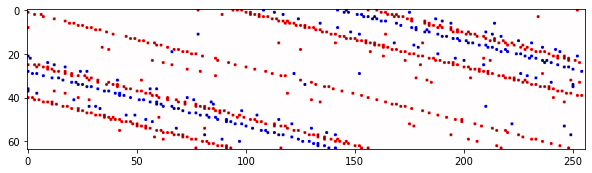

In [41]:
fig, ax = plt.subplots(figsize=(10,10))
_ = ax.imshow(It_event, cmap=plt.cm.seismic, vmin=-1, vmax=1)

In [42]:
It_event_ = torch.zeros((N_X, N_T))
It_event_[events[:, 0], events[:, 1]] = 1. * events[:, 2]

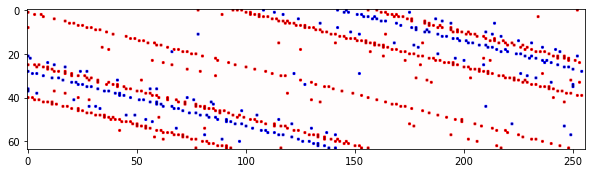

In [43]:
fig, ax = plt.subplots(figsize=(10,10))
_ = ax.imshow(It_event_, cmap=plt.cm.seismic, vmin=-1, vmax=1)

## construction of a constraint

In [44]:
events.shape

torch.Size([634, 3])

In [45]:
x_ = torch.linspace(-10, N_X+10, 100)
x = torch.remainder(x_, N_X)
N_X, x.min(), x.max()

(64, tensor(0.1818), tensor(63.8182))

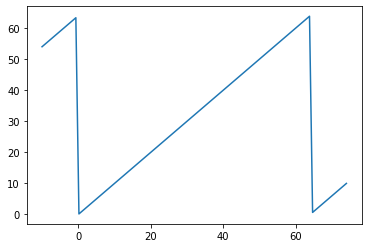

In [46]:
plt.plot(x_, x)

https://en.cppreference.com/w/cpp/numeric/math/fmod

In [47]:
u = 1.
events_u = 1 * events.clone().detach()
events_u[:, 0] = torch.remainder(events[:, 0] - u*N_X/N_T*events[:, 1], N_X)

In [48]:
events_u[:, 0].shape

torch.Size([634])

In [49]:
It_event_ = torch.zeros((N_X, N_T))
It_event_[events_u[:, 0], events_u[:, 1]] = 1. * events_u[:, 2]

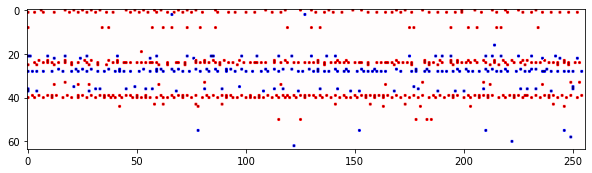

In [50]:
fig, ax = plt.subplots(figsize=(10,10))
_ = ax.imshow(It_event_, cmap=plt.cm.seismic, vmin=-1, vmax=1)

Compute occurences of events in space:


In [51]:
x = events[:, 0] - 1. * u*N_X/N_T*events[:, 1]
x

tensor([ 25.0000,   8.0000,  28.0000,  21.0000,  36.0000,  40.0000,  37.0000,
          1.0000,  21.7500,  28.5000,  39.5000,  40.2500,   1.2500,  24.2500,
         28.0000,  37.0000,  25.0000,  39.7500,  23.7500,   0.5000,  24.2500,
          1.2500,  40.2500,  28.2500,  24.7500,  23.7500,  21.7500,  39.7500,
         39.2500,  40.2500,  24.2500,  28.2500,  25.0000,  22.0000,   1.0000,
         34.0000,  39.7500,  27.5000,  24.5000,  28.0000,  40.0000,  24.7500,
         21.7500,   0.7500,  23.7500,  33.7500,  39.5000,   1.2500,  25.0000,
         24.0000,  40.0000,  28.0000,  35.7500,   0.7500,  27.5000,  28.2500,
         34.2500,  39.2500,  24.2500,   1.2500,  40.2500,  22.0000,   0.7500,
         27.7500,  39.7500,  23.5000,  21.2500,  24.2500,  28.2500,   1.2500,
         40.2500,  37.0000,  34.0000,  25.0000,   0.7500,  27.7500,  39.7500,
         23.7500,   1.2500,  40.2500,  36.2500,  24.0000,  28.0000,  25.0000,
          0.7500,  36.7500,  39.7500,   8.5000,  40.2500,  39.25

In [52]:
x = torch.remainder(x , N_X)
x, x.shape

(tensor([25.0000,  8.0000, 28.0000, 21.0000, 36.0000, 40.0000, 37.0000,  1.0000,
         21.7500, 28.5000, 39.5000, 40.2500,  1.2500, 24.2500, 28.0000, 37.0000,
         25.0000, 39.7500, 23.7500,  0.5000, 24.2500,  1.2500, 40.2500, 28.2500,
         24.7500, 23.7500, 21.7500, 39.7500, 39.2500, 40.2500, 24.2500, 28.2500,
         25.0000, 22.0000,  1.0000, 34.0000, 39.7500, 27.5000, 24.5000, 28.0000,
         40.0000, 24.7500, 21.7500,  0.7500, 23.7500, 33.7500, 39.5000,  1.2500,
         25.0000, 24.0000, 40.0000, 28.0000, 35.7500,  0.7500, 27.5000, 28.2500,
         34.2500, 39.2500, 24.2500,  1.2500, 40.2500, 22.0000,  0.7500, 27.7500,
         39.7500, 23.5000, 21.2500, 24.2500, 28.2500,  1.2500, 40.2500, 37.0000,
         34.0000, 25.0000,  0.7500, 27.7500, 39.7500, 23.7500,  1.2500, 40.2500,
         36.2500, 24.0000, 28.0000, 25.0000,  0.7500, 36.7500, 39.7500,  8.5000,
         40.2500, 39.2500, 28.2500, 25.0000,  1.0000, 39.7500, 23.7500,  8.7500,
         27.7500, 40.5000, 3

In [53]:
d = (x[:, None] - x[None, :])**2

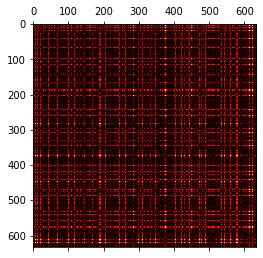

In [54]:
plt.matshow(d);

In [55]:
d.argmin(axis=1)

tensor([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
          2,   6,   0,  17,  18,  19,  13,  12,  11,  23,  24,  18,   8,  17,
         28,  11,  13,  23,   0,  33,   7,  35,  17,  37,  38,   2,   5,  24,
          8,  43,  18,  45,  10,  12,   0,  49,   5,   2,  52,  43,  37,  23,
         56,  28,  13,  12,  11,  33,  43,  63,  17,  65,  66,  13,  23,  12,
         11,   6,  35,   0,  43,  63,  17,  18,  12,  11,  80,  49,   2,   0,
         43,  85,  17,  87,  11,  28,  23,   0,   7,  17,  18,  95,  63,  97,
         28,  13,  12,   5,   2,  18,   8,  24,  37,   9, 108,  10,  11,  49,
          2,  17,  24,  85,  43,  12,  13,  28,  23,   5,  43,  52,  10,  97,
         38,  12,  23,  49,   5, 131,  63,  43,  10,  97,  38, 137,  12,   5,
         33,   2,  49,  24,  85,  95, 146,  19, 148,  12,  66,  23,  13,  11,
         35,   0,  43,  63,  17, 146,   9,  87,  97,   5,  49,   0,   7,  37,
         87,  10, 170,  11,  23,  12,  49,   6,  17,  43,  63,  

In [56]:
1000 * torch.eye(x.shape[0])

tensor([[1000.,    0.,    0.,  ...,    0.,    0.,    0.],
        [   0., 1000.,    0.,  ...,    0.,    0.,    0.],
        [   0.,    0., 1000.,  ...,    0.,    0.,    0.],
        ...,
        [   0.,    0.,    0.,  ..., 1000.,    0.,    0.],
        [   0.,    0.,    0.,  ...,    0., 1000.,    0.],
        [   0.,    0.,    0.,  ...,    0.,    0., 1000.]])

In [57]:
d = (x[:, None] - x[None, :])**2 + N_X**2 * torch.eye(x.shape[0])

In [58]:
d.argmin(axis=1)

tensor([ 16, 203,  14, 216,  52,  40,  15,  34,  26, 107,  46,  22,  21,  20,
          2,   6,   0,  27,  25, 147,  13,  12,  11,  31,  41,  18,   8,  17,
         57,  11,  13,  23,   0,  61,   7,  72,  17,  54, 126,   2,   5,  24,
          8,  53,  18, 210,  10,  12,   0,  81,   5,   2, 123,  43,  37,  23,
         35,  28,  13,  12,  11,  33,  43,  75,  17, 232, 150,  13,  23,  12,
         11,   6,  35,   0,  43,  63,  17,  18,  12,  11, 439,  49,   2,   0,
         43, 115,  17, 161,  11,  28,  23,   0,   7,  17,  18, 145,  63, 125,
         28,  13,  12,   5,   2,  18,   8,  24,  37,   9, 200,  10,  11,  49,
          2,  17,  24,  85,  43,  12,  13,  28,  23,   5,  43,  52,  10,  97,
         38,  12,  23,  49,   5,   3,  63,  43,  10,  97,  38, 334,  12,   5,
         33,   2,  49,  24,  85,  95, 159,  19, 236,  12,  66,  23,  13,  11,
         35,   0,  43,  63,  17, 146,   9,  87,  97,   5,  49,   0,   7,  37,
         87,  10, 313,  11,  23,  12,  49,   6,  17,  43,  63,  

In [59]:
d_min, ind = d.min(axis=1)
d_min

tensor([0.0000, 0.0625, 0.0000, 0.0000, 0.0625, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0625, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 

In [60]:
import torch.nn.functional as F
from torch import nn

In [61]:
mp = nn.MaxPool1d(x.shape[0])
mp

MaxPool1d(kernel_size=634, stride=634, padding=0, dilation=1, ceil_mode=False)

In [62]:
d.unsqueeze(0).shape

torch.Size([1, 634, 634])

In [63]:
mp(-d.unsqueeze(0)).shape

torch.Size([1, 634, 1])

In [64]:
mp(-d).shape

torch.Size([634, 1])

In [65]:
torch.sum(-mp(-d))

tensor(21.2500)

In [66]:
d_min = -F.max_pool1d(mp(-d), 1)
d_min.shape

torch.Size([634, 1])

In [67]:
events[events[:, 2] == 1, 0].shape, events[events[:, 2] == -1, 0].shape

(torch.Size([439]), torch.Size([195]))

In [68]:
p = -1
ind_p = events[:, 2] == p
x = events[ind_p, 0] - 1. * u*N_X/N_T*events[ind_p, 1]
x = torch.remainder(x , N_X)
d = (x[:, None] - x[None, :])**2 + N_X**2 * torch.eye(x.shape[0])        
d_min = -F.max_pool1d(-d, x.shape[0])

In [69]:
d_min.shape, d.shape

(torch.Size([195, 1]), torch.Size([195, 195]))

In [70]:
for u in [0, .5, 1, 1.5]:
    for p in [-1, 1]:
        ind_p = events[:, 2] == p
        x = events[ind_p, 0] - 1. * u*N_X/N_T*events[ind_p, 1]
        x = torch.remainder(x , N_X)
        d = (x[:, None] - x[None, :])**2 #+ N_X**2 * torch.eye(x.shape[0])        
        #d_min = -F.max_pool1d(-d, x.shape[0])
        #d_min, ind = d.min(axis=1)
        print(f'{u=:.2f}, {p=}, {d.mean().item():.2f}, {d.quantile(.2, axis=1).mean():.2f}')

u=0.00, p=-1, 650.88, 51.16
u=0.00, p=1, 683.39, 53.19
u=0.50, p=-1, 350.21, 61.00
u=0.50, p=1, 691.80, 51.82
u=1.00, p=-1, 117.06, 41.40
u=1.00, p=1, 438.21, 16.64
u=1.50, p=-1, 667.52, 141.83
u=1.50, p=1, 684.93, 60.55


In [71]:
d.quantile(.05, axis=1)

tensor([ 2.2141,  1.8906,  6.0766,  3.0203,  3.9516,  5.5828,  3.4703,  1.2656,
         1.5625,  3.5156,  0.9766,  4.4641,  0.7656,  5.5828,  4.4641,  0.9766,
         1.0000,  3.0625,  2.2500,  3.8641,  0.9562,  0.7656,  3.4703,  2.6406,
         2.2500,  1.2156,  1.8906,  1.0000,  1.0000,  1.2656,  3.0625,  2.2141,
         1.5328,  1.0000,  1.2656,  2.6016,  1.5328,  3.9516,  1.5625,  1.5625,
         1.2391,  2.2500,  1.2656,  1.8578,  1.2656,  1.5625,  1.5328,  1.5625,
         4.4641,  1.2656,  1.5328,  1.5328,  1.5062,  1.2391,  1.5625,  1.2391,
         1.2656,  2.2141,  1.5328,  3.0203,  1.0000,  1.2391,  1.2391,  1.8906,
         1.2656,  1.0000,  3.0203,  1.2656,  1.5625,  1.0000,  2.2141,  1.2391,
         1.0000,  1.0000,  3.9516,  1.8578,  1.2391,  1.0000,  1.8578,  1.0000,
         1.5625,  1.5625,  1.2391,  2.2141,  1.5328,  2.2141,  2.2141,  1.8578,
         1.2656,  2.2141,  1.8906,  1.8906,  1.2391,  1.5328,  2.2500,  1.5625,
         1.8281,  1.5625,  2.2141,  1.89

In [72]:
x = events[ind_p, 0] - 1 * u*N_X/N_T*events[ind_p, 1]
x = torch.remainder(x, N_X)
x = x.to(torch.long)

In [73]:
torch.unique?

Signature: torch.unique(*args, **kwargs)
Docstring:
Returns the unique elements of the input tensor.

.. note:: This function is different from :func:`torch.unique_consecutive` in the sense that
    this function also eliminates non-consecutive duplicate values.

.. note:: Currently in the CUDA implementation and the CPU implementation when dim is specified,
    `torch.unique` always sort the tensor at the beginning regardless of the `sort` argument.
    Sorting could be slow, so if your input tensor is already sorted, it is recommended to use
    :func:`torch.unique_consecutive` which avoids the sorting.

Args:
    input (Tensor): the input tensor
    sorted (bool): Whether to sort the unique elements in ascending order
        before returning as output.
    return_inverse (bool): Whether to also return the indices for where
        elements in the original input ended up in the returned unique list.
    return_counts (bool): Whether to also return the counts for each unique
        

In [74]:
_, counts = torch.unique_consecutive(x, return_counts=True) 

In [75]:
_, counts = torch.unique(x, return_counts=True) 

In [76]:
x, counts

(tensor([25,  8, 40,  1, 39, 39,  0, 23, 24, 39, 23, 63, 23,  0, 39, 23, 22, 38,
         37, 38, 22, 23, 63, 32, 38, 22, 38, 22, 62, 21, 31, 37, 62, 22, 21, 37,
         62, 31, 36, 21, 62, 37, 61, 36, 20, 20, 61, 36, 30, 21, 61, 36, 20, 61,
         36, 20, 21, 60, 35,  4, 35, 34, 20, 60, 35, 19,  4, 35, 34, 19, 60, 35,
         18, 19, 39, 34, 34, 18, 34, 19, 59, 59, 18, 33, 34, 58, 33, 34, 18, 58,
         17, 33, 12, 58, 32, 33, 17, 58, 33, 17, 17,  1, 36, 57, 57, 16, 32, 26,
         17, 57, 32, 35,  0, 32, 32, 16, 17, 57,  0, 31, 31, 56, 15, 31, 56, 16,
         56, 30, 31, 15, 16, 63, 55, 30, 55, 30, 55, 14, 15, 30, 34, 34, 62, 14,
         55, 30, 14, 13, 23, 29, 13, 29, 13, 29, 53, 13, 61, 29, 54, 13, 14, 32,
         28, 12, 27, 28, 53, 12, 28, 28, 12, 53, 13, 28, 11, 27, 11, 27, 52, 11,
         26, 27, 27, 52, 11, 11, 27, 26, 10, 26, 11, 51, 25, 26, 51, 10,  9, 25,
         35, 25, 19,  9, 50, 25, 49, 25,  8,  9, 24, 57, 25,  9, 24, 24,  8, 49,
         35, 24, 24, 23,  8,

In [77]:
p = counts/(N_X * 2)
entropy = torch.sum(p* torch.log2(p))*-1
entropy

tensor(13.9185)

Kolmogorov Smirnov


In [78]:
x = events[ind_p, 0] - 1 * u*N_X/N_T*events[ind_p, 1]
x = torch.remainder(x, N_X)
x = x.to(torch.long)
x, _ = x.sort()
x

tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  2,  2,
         2,  2,  2,  2,  2,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,  4,  4,  5,
         5,  5,  5,  5,  5,  5,  6,  6,  6,  7,  7,  7,  7,  7,  7,  7,  8,  8,
         8,  8,  8,  8,  8,  8,  8,  9,  9,  9,  9,  9,  9,  9,  9,  9, 10, 10,
        10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 12,
        12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13,
        13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15,
        15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 17, 17, 17, 17, 17, 17, 17, 17,
        17, 17, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 19, 19, 19, 19, 19, 19,
        19, 19, 19, 19, 19, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 21, 21, 21,
        21, 21, 21, 21, 21, 21, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22,
        22, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 24, 24, 24, 24, 24, 24,
        24, 25, 25, 25, 25, 25, 25, 25, 

In [79]:
torch.sum(

SyntaxError: unexpected EOF while parsing (2803520024.py, line 1)

## gradient descent optimization

In [ ]:
import torch
torch.set_default_tensor_type("torch.DoubleTensor")

In [ ]:
class EMD(torch.nn.Module):
    def __init__(self, u=0.5):
        super(EMD, self).__init__()
        self.u = torch.nn.Parameter(u * torch.ones(1), requires_grad=True)
        self.polarities = [-1, 1]
    def forward(self, events):
        loss = 0
        for p in self.polarities:
            ind_p = events[:, 2] == p
            x = events[ind_p, 0] - 1. * self.u*N_X/N_T*events[ind_p, 1]
            x = torch.remainder(x , N_X)
            d = (x[:, None] - x[None, :])**2 + N_X**2 * torch.eye(x.shape[0])        
            d_min = -F.max_pool1d(-d, x.shape[0])
            loss += torch.sum(d_min)
        return loss

In [ ]:
class EMD(torch.nn.Module):
    def __init__(self, u=0.5):
        super(EMD, self).__init__()
        self.u = torch.nn.Parameter(u * torch.ones(1), requires_grad=True)
        self.polarities = [-1, 1]
    def forward(self, events):
        loss = 0
        for p in self.polarities:
            ind_p = events[:, 2] == p
            x = events[ind_p, 0] - 1. * self.u*N_X/N_T*events[ind_p, 1]
            x = torch.remainder(x , N_X)
            d = (x[:, None] - x[None, :])**2
            loss += torch.mean(d)
        return loss

In [ ]:
class EMD(torch.nn.Module):
    def __init__(self, u=0.5):
        super(EMD, self).__init__()
        self.u = torch.nn.Parameter(u * torch.ones(1), requires_grad=True)
        self.polarities = [-1, 1]
    def forward(self, events):
        loss = 0
        for p in self.polarities:
            ind_p = events[:, 2] == p
            x = events[ind_p, 0] - 1. * self.u*N_X/N_T*events[ind_p, 1]
            x = torch.remainder(x , N_X)
            x = x.to(torch.long)
            _, counts = torch.unique(x, return_counts=True)  # unique_consecutive
            p = counts / (N_X * 2)
            loss += torch.sum(p* torch.log2(p))*-1
        return loss

In [86]:
class EMD(torch.nn.Module):
    def __init__(self, u=0.5):
        super(EMD, self).__init__()
        self.u = torch.nn.Parameter(u * torch.ones(1), requires_grad=True)
        self.polarities = [-1, 1]
    def forward(self, events):
        ind_pos = events[:, 2] == 1
        x_pos = events[ind_pos, 0] - 1. * self.u*N_X/N_T*events[ind_pos, 1]
        x_pos = torch.remainder(x_pos , N_X)
        ind_neg = events[:, 2] == -1
        x_neg = events[ind_neg, 0] - 1. * self.u*N_X/N_T*events[ind_neg, 1]
        x_neg = torch.remainder(x_neg , N_X)
        d = (x_pos[:, None] - x_neg[None, :])**2
        d_min = -F.max_pool1d(-d, x_neg.shape[0])
        loss = d.mean()-torch.mean(d_min)
        return loss

In [88]:
class EMD(torch.nn.Module):
    def __init__(self, u=0.5):
        super(EMD, self).__init__()
        self.u = torch.nn.Parameter(u * torch.ones(1), requires_grad=True)
        self.polarities = [-1, 1]
    def forward(self, events):
        loss = 0
        for p in self.polarities:
            ind_p = events[:, 2] == p
            x = events[ind_p, 0] - 1. * self.u*N_X/N_T*events[ind_p, 1]
            x = torch.remainder(x , N_X)
            d = (x[:, None] - x[None, :])**2
            loss += d.quantile(.2, axis=1).sqrt().mean()
        return loss

In [89]:
learning_rate = 0.01
beta1, beta2 = 0.9, 0.999
betas = (beta1, beta2)
num_epochs = 2 ** 10 + 1

def fit_data(events, learning_rate=learning_rate, 
             num_epochs=num_epochs, betas=betas, verbose=True):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    N_X, N_T = It_event.shape
    P_uniform = torch.ones(N_X) / N_X
    events = events.to(device)
        
    emd = EMD()
    emd = emd.to(device)
    emd.train()
    
    #optimizer = torch.optim.Adam(emd.parameters(), lr=learning_rate, betas=betas)
    optimizer = torch.optim.SGD(emd.parameters(), lr=learning_rate)
    
    for epoch in range(int(num_epochs)):
        loss = emd(events)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if verbose and (epoch % (num_epochs // 32) == 0):
            print(f"Iteration: {epoch} - u={emd.u.detach().item():.3f} Loss: {loss.item():.3f}")

    return emd, loss

emd, loss = fit_data(events, verbose=True)

Iteration: 0 - u=0.503 Loss: 12.481
Iteration: 32 - u=1.023 Loss: 9.901
Iteration: 64 - u=0.999 Loss: 9.862
Iteration: 96 - u=1.016 Loss: 9.937
Iteration: 128 - u=1.045 Loss: 6.956
Iteration: 160 - u=0.955 Loss: 6.303
Iteration: 192 - u=0.993 Loss: 9.955
Iteration: 224 - u=0.925 Loss: 6.338
Iteration: 256 - u=1.067 Loss: 6.404
Iteration: 288 - u=1.026 Loss: 9.898
Iteration: 320 - u=0.967 Loss: 9.696
Iteration: 352 - u=1.012 Loss: 10.032
Iteration: 384 - u=1.060 Loss: 6.341
Iteration: 416 - u=1.039 Loss: 6.313
Iteration: 448 - u=1.075 Loss: 6.666
Iteration: 480 - u=0.985 Loss: 9.778
Iteration: 512 - u=0.955 Loss: 9.726
Iteration: 544 - u=0.989 Loss: 9.668
Iteration: 576 - u=0.908 Loss: 6.652
Iteration: 608 - u=1.030 Loss: 6.359
Iteration: 640 - u=1.010 Loss: 10.052
Iteration: 672 - u=1.048 Loss: 6.782
Iteration: 704 - u=1.045 Loss: 6.392
Iteration: 736 - u=0.985 Loss: 6.324
Iteration: 768 - u=0.929 Loss: 6.445
Iteration: 800 - u=1.018 Loss: 6.507
Iteration: 832 - u=0.895 Loss: 6.648
Ite

In [ ]:
emd.u